# Homework 7

Name: Kavana Manvi Krishnamuthy

ID: 2158984

In [3]:
import cv2
import matplotlib.pyplot as plt
print(cv2.__version__)

4.10.0


In [4]:
image1_path="/Users/kavanamanvi/Desktop/IIP/HW7/inputs/image_1.jpeg"
image2_path="/Users/kavanamanvi/Desktop/IIP/HW7/inputs/image_2.jpeg"
image3_path="/Users/kavanamanvi/Desktop/IIP/HW7/inputs/image_3.jpeg"

In [5]:
image_paths = [image1_path,image2_path,image3_path] 

## Part 1 – Locating the Blue Piece

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def fetch_and_process(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    # mask for the blue pixels
    blue_region_mask = cv2.inRange(hsv_img, np.array([90, 50, 50]),  np.array([130, 255, 255]))
    # remove the noise
    kernel_shape = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    blue_region_mask = cv2.morphologyEx(blue_region_mask, cv2.MORPH_OPEN, kernel_shape)
    blue_region_mask = cv2.morphologyEx(blue_region_mask, cv2.MORPH_CLOSE, kernel_shape)
     # non-blue area is darkened
    masked_img = img_rgb.copy()
    masked_img[blue_region_mask == 0] = masked_img[blue_region_mask == 0] * 0
    return img_rgb, blue_region_mask, masked_img

In [9]:
def show_results(original, mask, highlighted):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Picture")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Binary Mask")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(highlighted)
    plt.title("Blue Area Highlighted")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

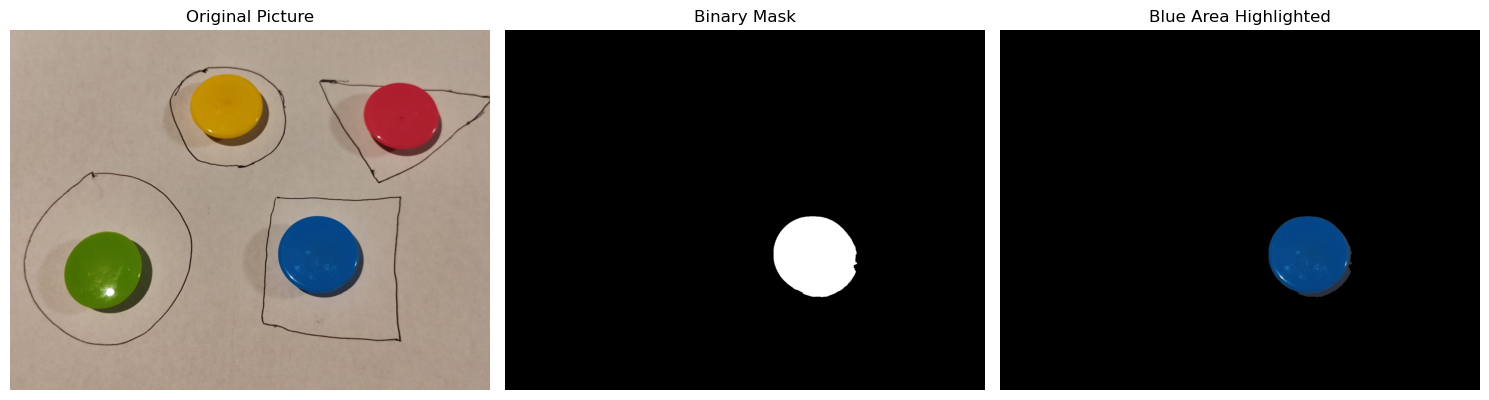

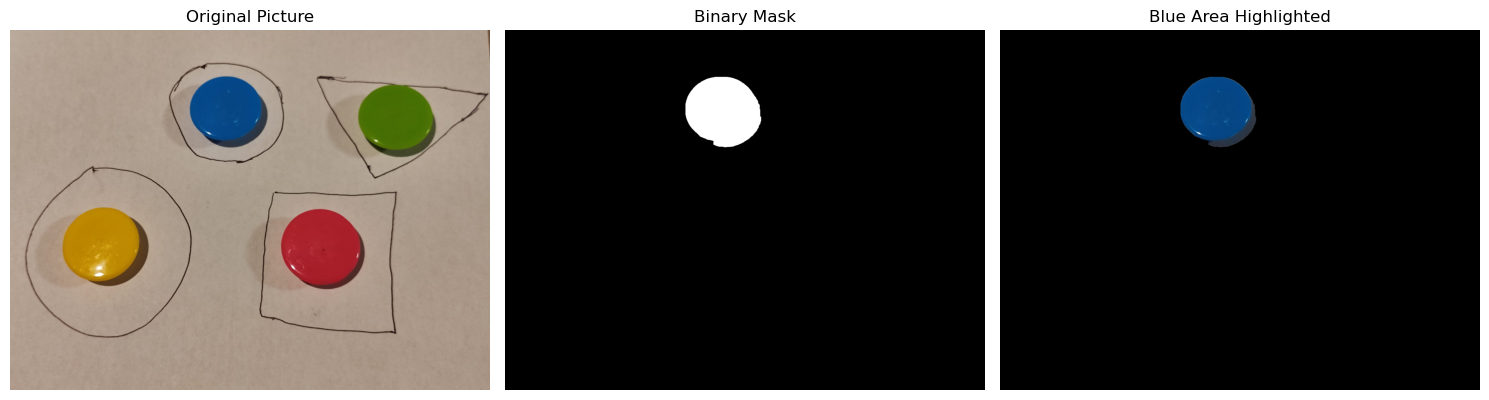

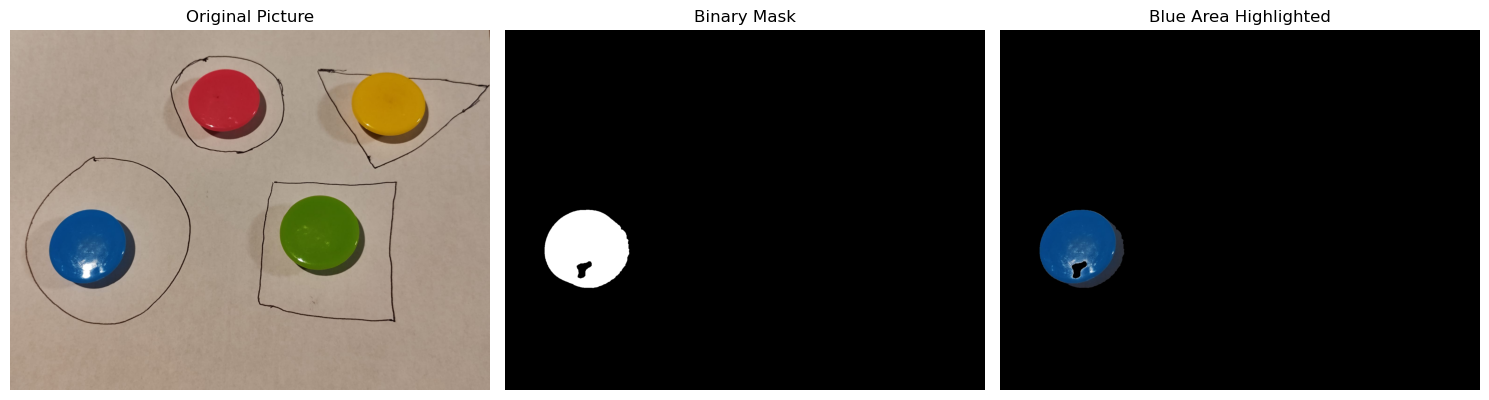

In [10]:
for image_path in image_paths:
    original_img, blue_mask, highlighted_img = fetch_and_process(image_path)
    show_results(original_img, blue_mask, highlighted_img)

## Part 2 – Locating the Boundaries of the Shapes

In [12]:
def refined_bin_boundry(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    blue_area_mask = cv2.inRange(hsv_img, np.array([90, 50, 50]),  np.array([130, 255, 255]))
    kernel_type = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    blue_area_mask = cv2.morphologyEx(blue_area_mask, cv2.MORPH_CLOSE, kernel_type)
    blue_area_mask = cv2.morphologyEx(blue_area_mask, cv2.MORPH_OPEN, kernel_type)
    bw_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binarized_img = cv2.threshold(bw_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel_struct = np.ones((5, 5), np.uint8)
    refined_bw_image = cv2.morphologyEx(binarized_img, cv2.MORPH_CLOSE, kernel_struct)
    enhanced_boundaries = cv2.bitwise_and(refined_bw_image, cv2.bitwise_not(blue_area_mask))
    enhanced_boundaries = cv2.bitwise_not(enhanced_boundaries)
    inverted_refined_bw_image = cv2.bitwise_not(refined_bw_image)

    return inverted_refined_bw_image, enhanced_boundaries

In [13]:
def process_part2(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    boundaries,refined_boundaries   = refined_bin_boundry(image)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    
    ax[1].imshow(boundaries, cmap='gray')
    ax[1].set_title("Refined Binary Boundaries")
    
    ax[2].imshow(refined_boundaries, cmap='gray')
    ax[2].set_title("Boundaries Without Blue Piece")
    
    for a in ax:
        a.axis("off")
    
    plt.show()

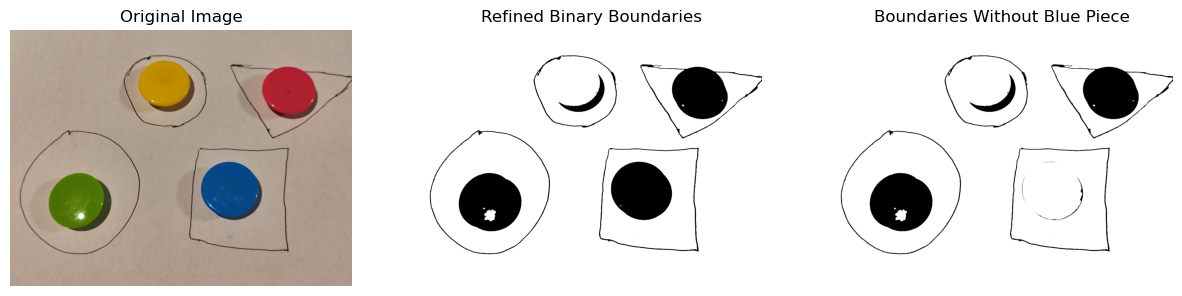

In [14]:
process_part2(image1_path)

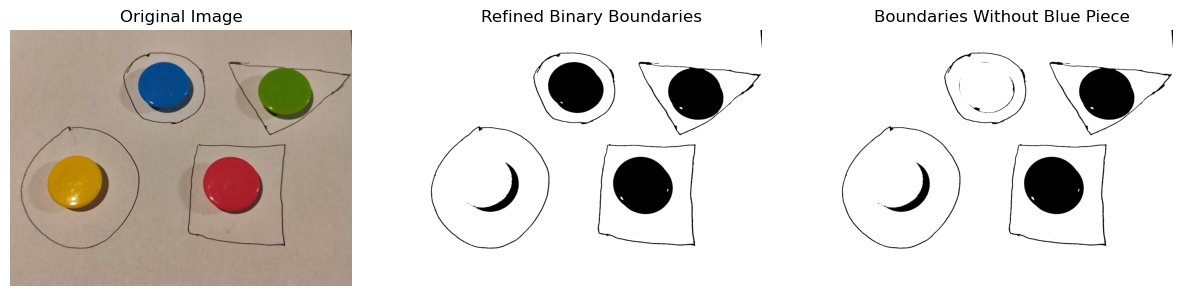

In [15]:
process_part2(image2_path)

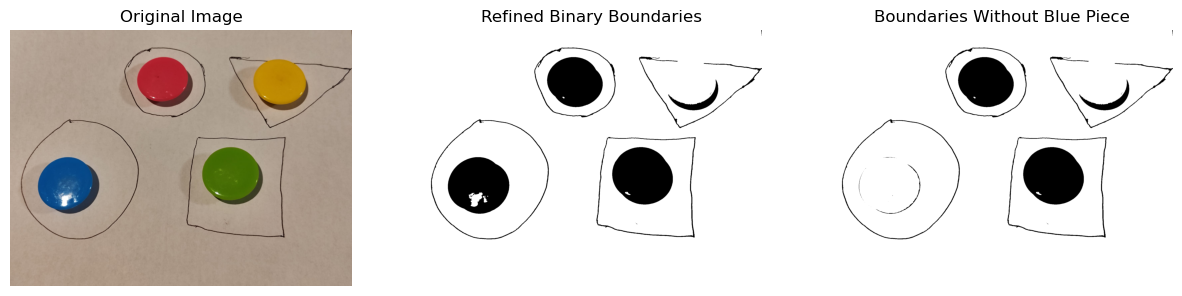

In [16]:
process_part2(image3_path)

## Part 3 – Locating the Target Shape

In [18]:
def detect_blue_region(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    blue_segment = cv2.inRange(hsv_img,np.array([90, 50, 50]), np.array([130, 255, 255]))
    struct_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
    blue_segment = cv2.morphologyEx(blue_segment, cv2.MORPH_CLOSE, struct_element)
    blue_segment = cv2.morphologyEx(blue_segment, cv2.MORPH_OPEN, struct_element)
    blue_segment = cv2.dilate(blue_segment, struct_element, iterations=1)
    return blue_segment

In [19]:
def identify_shape_edges(img):
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, binary_map = cv2.threshold(grayscale_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    processed_edges = cv2.morphologyEx(binary_map, cv2.MORPH_CLOSE, kernel)
    return processed_edges

In [20]:
def exclude_blue_from_edges(edge_map, blue_segment):
    adjusted_edges = cv2.bitwise_and(edge_map, cv2.bitwise_not(blue_segment))
    adjusted_edges = cv2.bitwise_not(adjusted_edges)
    return adjusted_edges

In [21]:
def compute_connected_areas(bin_image):
    total_labels, label_map = cv2.connectedComponents(bin_image)
    return total_labels, label_map

In [22]:
def extract_blue_object_mask(label_map, blue_segment):
    matching_labels = np.unique(label_map[blue_segment == 255])
    target_mask = np.isin(label_map, matching_labels).astype(np.uint8) * 255
    return target_mask

In [23]:
def emphasize_blue_container(img, label_map, blue_segment):
    relevant_labels = np.unique(label_map[blue_segment == 255])
    object_mask = np.isin(label_map, relevant_labels).astype(np.uint8)
    output_img = img.copy()
    output_img[object_mask == 1] = [0, 0, 255]  # Apply solid blue fill
    output_img[blue_segment == 255] = img[blue_segment == 255]  # Preserve original blue region
    return output_img

In [24]:
def display_imgs(file_path):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    blue_region = detect_blue_region(img)
    shape_edges = identify_shape_edges(img)
    filtered_edges = exclude_blue_from_edges(shape_edges, blue_region)
    inverted_edges = cv2.bitwise_not(shape_edges)  
    
    total_labels, label_map = compute_connected_areas(filtered_edges)
    blue_object_mask = extract_blue_object_mask(label_map, blue_region)
    highlighted_object = emphasize_blue_container(img, label_map, blue_region)
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    
    ax[1].imshow(blue_object_mask, cmap='gray')
    ax[1].set_title("Binary Mask of Blue Object")
    
    ax[2].imshow(highlighted_object)
    ax[2].set_title("Highlighted Shape Containing Blue Region")
    
    for a in ax:
        a.axis("off")
    
    plt.show()

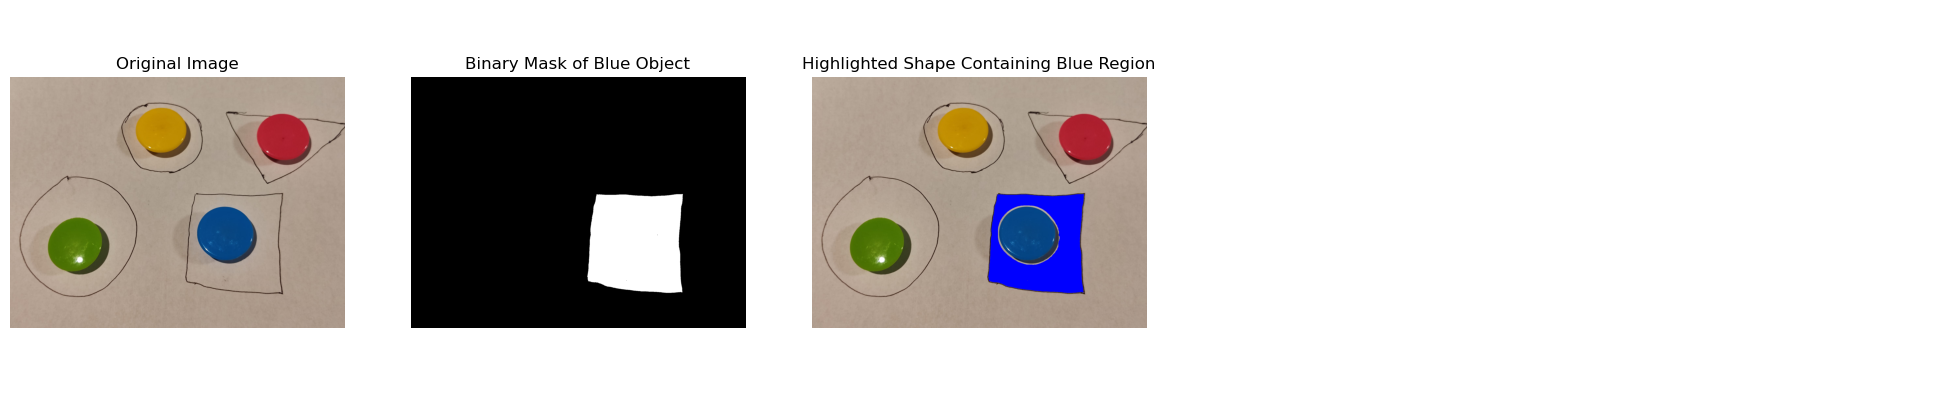

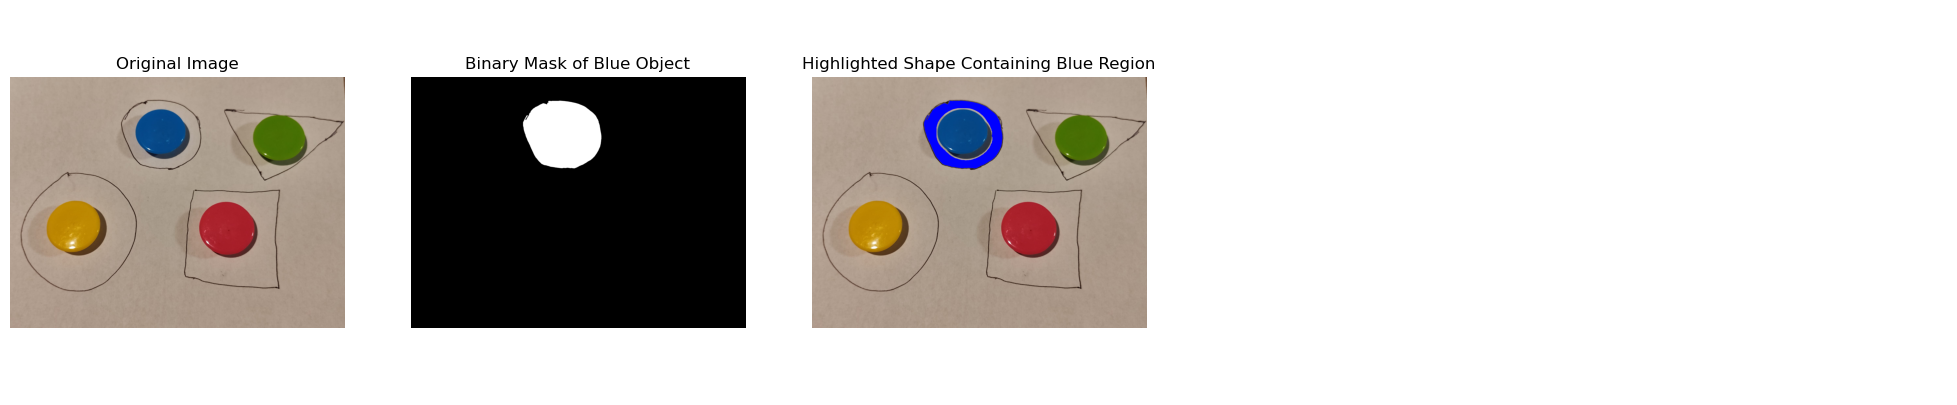

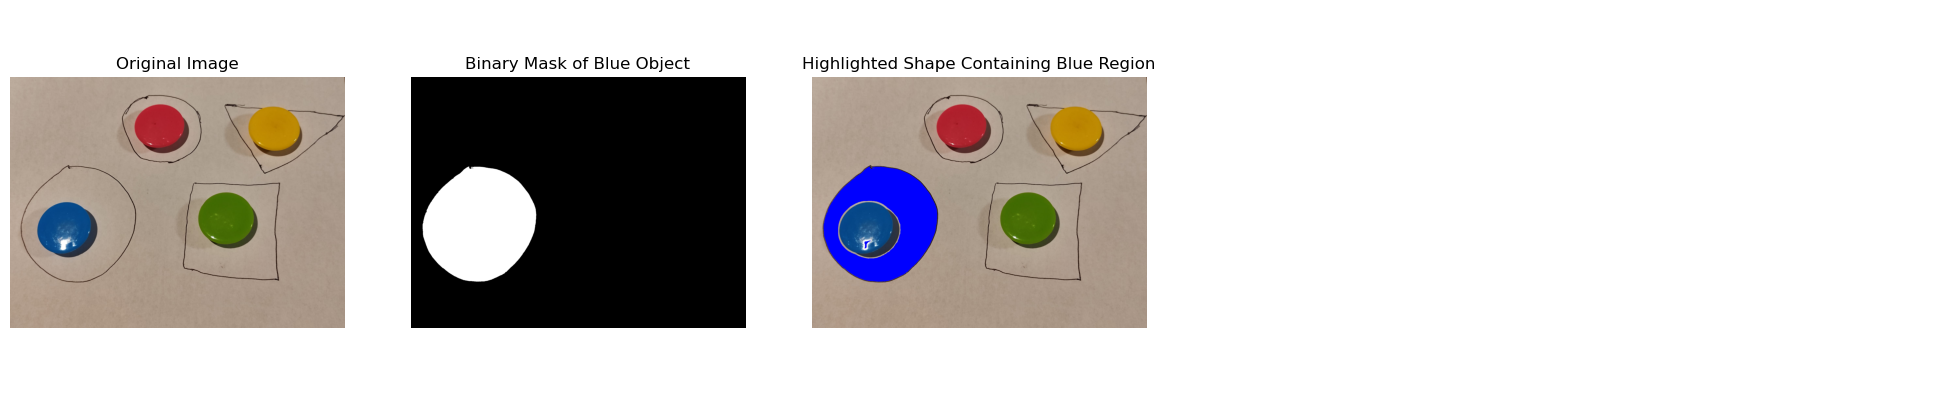

In [25]:
for image_path in image_paths:
    display_imgs(image_path)